In [6]:
!pip install -q -U google-generativeai pandas scikit-learn

In [7]:
import google.generativeai as genai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [9]:
data_fraud = pd.read_csv("creditcard.csv")
data_fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
data_fraud['Class'].value_counts()

,count
Class,
0,284315
1,492


In [11]:

data_fraud['Class'].dropna().value_counts(normalize=True)

,proportion
Class,
0,0.998273
1,0.001727


In [12]:
data_fraud = data_fraud.dropna()
X = data_fraud.drop('Class', axis=1)
y = data_fraud['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred_baseline = model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
print(classification_report(y_test, y_pred_baseline))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.68      0.63      0.65       142

    accuracy                           1.00     85443
   macro avg       0.84      0.81      0.83     85443
weighted avg       1.00      1.00      1.00     85443



<Axes: >

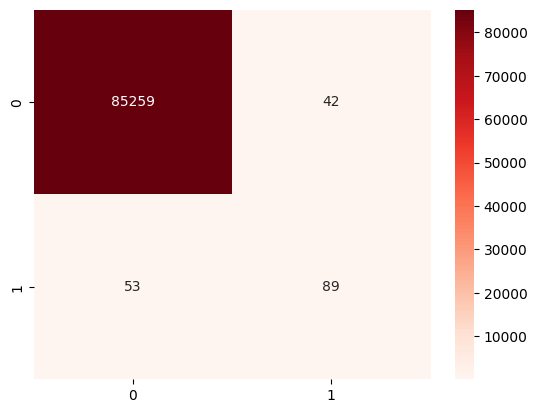

In [14]:
sns.heatmap(confusion_matrix(y_test, y_pred_baseline),annot=True,fmt='d',cmap='Reds')

In [15]:
df_fraud_reals = X_train[y_train == 1].sample(5)

few_shot_examples = ''

for i, row in df_fraud_reals.iterrows():
  few_shot_examples += f"Exemplo de transação fraudulenta {i+1}:\n"
  few_shot_examples += str(row.to_dict()) + "\n\n"


prompt_geracao = f"""
Você é um especialista em ciência de dados simulando dados para um modelo de detecção de fraude.
Com base nos exemplos de transações fraudulentas abaixo, gere 10 novos exemplos de transações fictícias, mas realistas, que sigam um padrão similar.
Retorne apenas os dicionários de dados, um por linha, sem texto adicional.

{few_shot_examples}

Gere 10 novos exemplos aqui:
"""

In [25]:
model_gen = genai.GenerativeModel('gemini-2.5-flash')
response = model_gen.generate_content(prompt_geracao)

In [26]:
new_fraud = []
for line in response.text.strip().split('\n'):
    try:
        new_fraud.append(ast.literal_eval(line))
    except:
        continue

df_novas_fraudes = pd.DataFrame(new_fraud)

In [27]:
df_novas_fraudes['Class'] = 1

In [28]:
df_novas_fraudes

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,58765.0,-4.512346,3.123457,-4.890123,4.101123,-2.987654,-1.567890,-4.901235,1.987654,-1.543211,...,0.890123,0.345679,0.456789,-0.234568,-0.678901,-0.312346,-1.234568,0.567890,0.99,1
1,38234.0,-3.987654,4.234568,-4.123457,5.234568,-3.890123,-1.012346,-6.543211,2.789012,-4.876543,...,1.567890,0.890123,-0.234568,0.056789,0.123457,0.389012,0.567890,0.456789,5.23,1
2,81234.0,-3.567890,2.876543,-5.432110,3.987654,-1.789012,-1.901235,-5.234568,2.345679,-2.765432,...,0.789012,-0.056789,-0.567890,-0.678901,0.123457,-0.156789,1.123457,0.056789,1.25,1
3,60123.0,-4.123457,3.123457,-3.234568,3.567890,-1.890123,-1.123457,-3.567890,-1.012346,-1.876543,...,2.123457,-0.987654,-0.345679,0.123457,0.034568,-0.456789,-1.456789,-0.890123,42.34,1
4,45678.0,-10.567890,6.123457,-12.890123,7.123457,-10.123457,-2.567890,-11.987654,7.012346,-7.123457,...,2.012346,-1.123457,-0.012346,0.567890,0.389012,-0.389012,-0.678901,-0.789012,180.50,1
5,72101.0,-5.501235,2.809877,-5.801235,5.098765,-3.501235,-1.209877,-6.001235,1.809877,-0.801235,...,0.701235,0.509877,0.501235,-0.109877,-0.701235,-0.309877,-1.501235,0.709877,2.10,1
6,32876.0,-4.001235,4.609877,-4.501235,5.609877,-4.201235,-1.309877,-6.901235,2.909877,-5.001235,...,1.701235,0.909877,-0.201235,0.059877,0.101235,0.409877,0.601235,0.509877,3.80,1
7,87654.0,-3.401235,3.009877,-5.701235,3.909877,-1.901235,-1.909877,-5.601235,2.509877,-2.901235,...,0.901235,-0.109877,-0.601235,-0.709877,0.101235,-0.109877,1.201235,0.109877,0.85,1
8,61234.0,-4.401235,3.309877,-3.101235,3.509877,-2.001235,-1.309877,-3.401235,-1.209877,-2.001235,...,2.101235,-1.009877,-0.301235,0.109877,0.001235,-0.509877,-1.601235,-1.009877,50.15,1
9,40123.0,-11.001235,6.009877,-13.001235,7.009877,-10.501235,-2.809877,-12.001235,7.009877,-7.001235,...,2.001235,-1.209877,-0.001235,0.609877,0.301235,-0.409877,-0.601235,-0.809877,165.75,1


# Modelo de regressão logistica usando dados feito por uma LLM para aumentar o seu treinamento e aumentar se desempenho:

In [29]:
X_train_aumentado = pd.concat([X_train, df_novas_fraudes.drop('Class', axis=1)], ignore_index=True)
y_train_aumentado = pd.concat([y_train, df_novas_fraudes['Class']], ignore_index=True)

model_melhorado = LogisticRegression()
model_melhorado.fit(X_train_aumentado, y_train_aumentado)
y_pred_melhorado = model_melhorado.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
print("\n--- Resultado do Modelo Baseline com dados total originais: ---")
print(classification_report(y_test, y_pred_baseline))

print("\n--- Resultado do Modelo Aprimorado com novos dados sintéticos: ---")
print(classification_report(y_test, y_pred_melhorado))


--- Resultado do Modelo Baseline com dados total originais: ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.68      0.63      0.65       142

    accuracy                           1.00     85443
   macro avg       0.84      0.81      0.83     85443
weighted avg       1.00      1.00      1.00     85443


--- Resultado do Modelo Aprimorado com novos dados sintéticos: ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.83      0.60      0.69       142

    accuracy                           1.00     85443
   macro avg       0.91      0.80      0.85     85443
weighted avg       1.00      1.00      1.00     85443



Text(0.5, 1.0, 'Matriz de Confusão - Modelo Baseline com dados total originais:')

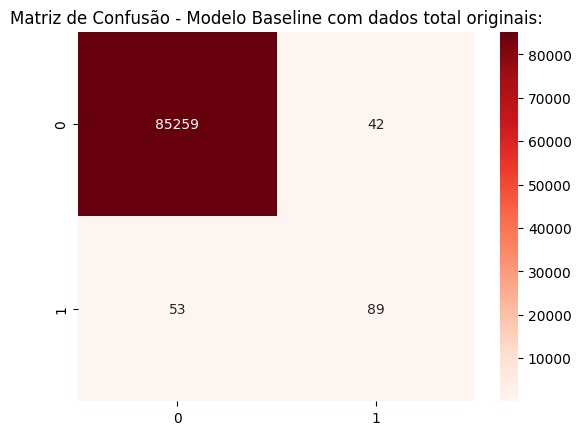

In [31]:
sns.heatmap(confusion_matrix(y_test, y_pred_baseline), annot=True, fmt='d', cmap='Reds')
plt.title('Matriz de Confusão - Modelo Baseline com dados total originais:')

Text(0.5, 1.0, 'Matriz de Confusão - Modelo Aprimorado com novos dados sintéticos:')

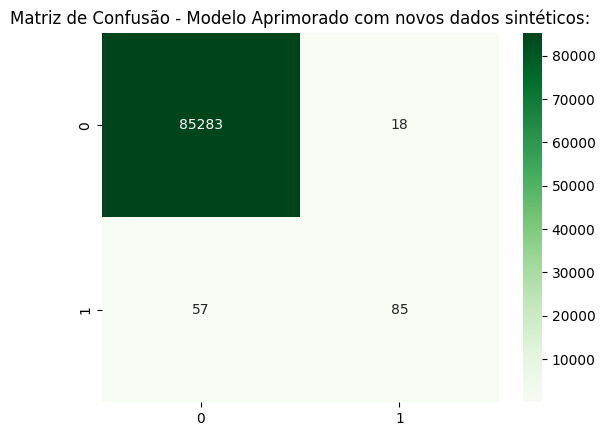

In [32]:
sns.heatmap(confusion_matrix(y_test, y_pred_melhorado), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão - Modelo Aprimorado com novos dados sintéticos:')